12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\santi\Anaconda3\envs\gpu_2_copy\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dates = pd.date_range(


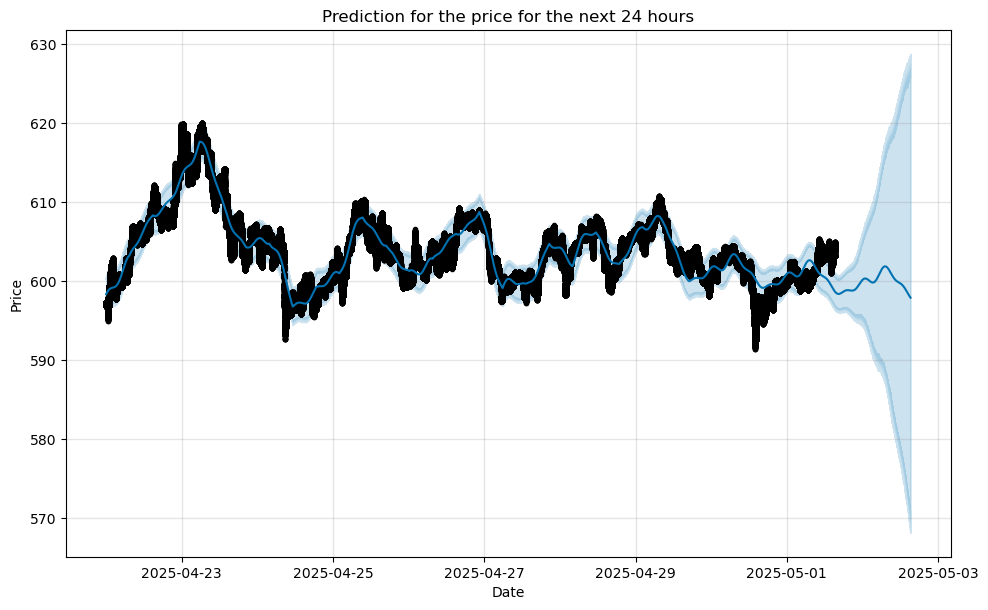

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from utils import get_data_crypto

from dotenv import load_dotenv

from binance.client import Client

from prophet import Prophet
import xgboost  as xgb

import  requests


import os  

def prophet_model(data, time):
    if len(data.columns) > 2:
        raise ValueError('Your dataset has more than two columns {data.columns}')
    
    data.columns = ['ds','y']

    model = Prophet(daily_seasonality=True)
    model.fit(data)

    if time == 'min':
        future = model.make_future_dataframe(periods=24*60, freq = time)
    elif time == 'S':
        future = model.make_future_dataframe(periods=24*60*60, freq = time)
    else:
        raise ValueError('Please write a correct option for time ("S" or "min")')
    
    df = model.predict(future)

    fig1 = model.plot(df)
    plt.title('Prediction for the price for the next 24 hours')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()

    df = df[['ds', 'yhat_lower', 'yhat', 'yhat_upper' ]]
    # df =df.rename({'yhat':'y', 'yhat_lower':''})

    predict = df[df['ds'] >= data['ds'].max()]
    
    return data, predict

from utils import get_data_crypto, models

data = get_data_crypto().download_data(start_time='2025-04-22', end_time='2025-05-01 15:16:00', crypto="BNBUSDT", time='S')
df_prophet, predict_prophet = prophet_model(data=data, time='S')


Index(['ds', 'yhat_lower', 'yhat', 'yhat_upper'], dtype='object')


C:\Users\santi\AppData\Local\Temp\ipykernel_18324\2503634855.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  model['ds'] = model['ds'].dt.round(time)
C:\Users\santi\AppData\Local\Temp\ipykernel_18324\2503634855.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  data['ds'] = data['ds'].dt.round(time)


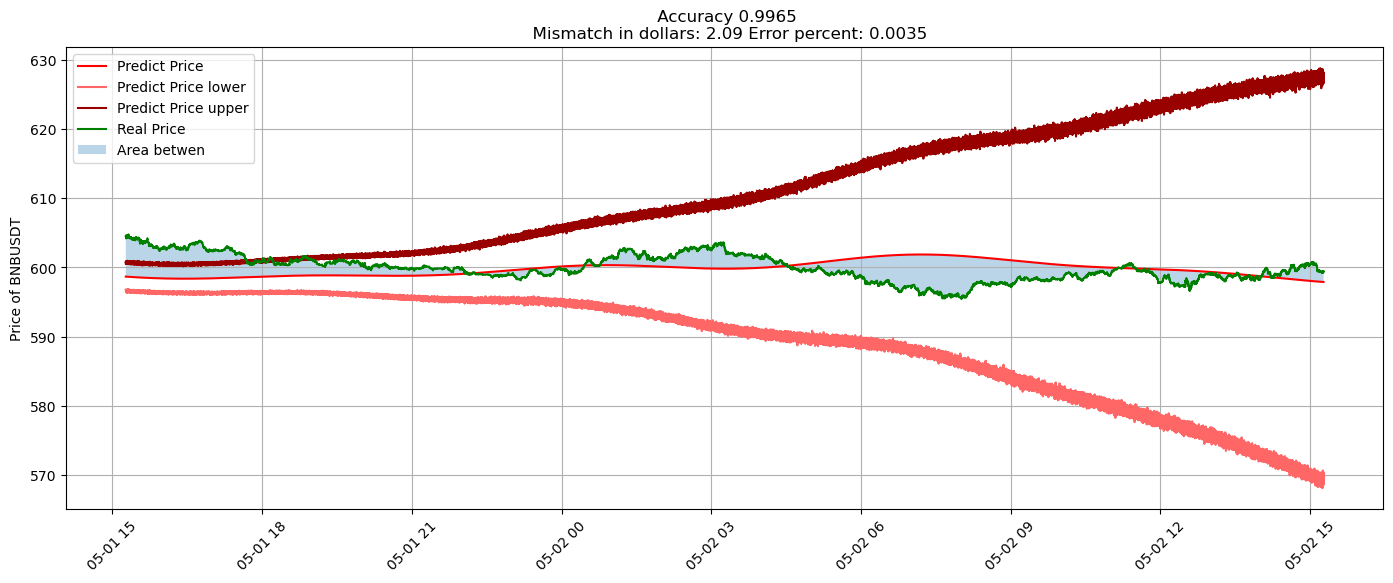

In [ ]:
import matplotlib.dates as mdates

def data_predict(model_pred, time, crypto ):
    model = model_pred.copy()

    model = model[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
    # model = model.rename(columns={'yhat_lower': 'predict price'})

    model = model[model['ds']>=model['ds'].max() - pd.Timedelta(minutes=24*60)]

    # data = get_data_crypto().download_data_cloud(start_time=model['ds'].max() - pd.Timedelta(minutes=24*60) , end_time=model['ds'].max(), crypto=crypto, time=time)
    data = get_data_crypto().download_data(start_time =model['ds'].max() - pd.Timedelta(minutes=24*60) , end_time=model['ds'].max(), crypto=crypto, time=time)
    data.columns = ['ds','real price']

    if time == 'min':
        model['ds'] = model['ds'].dt.round(time)
        data['ds'] = data['ds'].dt.round(time)
        
    elif time == 'S':
        model['ds'] = model['ds'].dt.round(time)
        data['ds'] = data['ds'].dt.round(time)
    else:
        raise ValueError(f'Please write a correct option for the time {time}')


    df = pd.merge(left=model, right=data, on='ds', how='left')
    df = df.dropna(axis=0).reset_index(drop=True)

    df['difference'] = np.absolute(df['yhat'] - df['real price'])
    df['mismatch'] = df['difference']/df['real price']

    difference_shadow = round(np.trapz(df['difference'], x=mdates.date2num(df['ds'])), 2)
    mismatch_percent = round(np.trapz(df['mismatch'], x=mdates.date2num(df['ds'])), 4)

    plt.figure(figsize=(17,6))
    plt.plot(df['ds'], df['yhat'], c='r', label = 'Predict Price' )
    plt.plot(df['ds'], df['yhat_lower'], c='#FF6666', label = 'Predict Price lower' )
    plt.plot(df['ds'], df['yhat_upper'], c='#990000', label = 'Predict Price upper' )

    plt.plot(df['ds'], df['real price'], c='g', label='Real Price')

    plt.fill_between(df['ds'], df['real price'], df['yhat'], alpha=0.3, label='Area betwen')

    plt.title(f' Accuracy {1-mismatch_percent}\n  Mismatch in dollars: {difference_shadow} Error percent: {mismatch_percent}')
    plt.ylabel(f'Price of {crypto}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    
    return df




test_1 = data_predict(model_pred=predict_prophet, crypto="BNBUSDT", time='S')

14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:34 - cmdstanpy - INFO - Chain [1] done processing


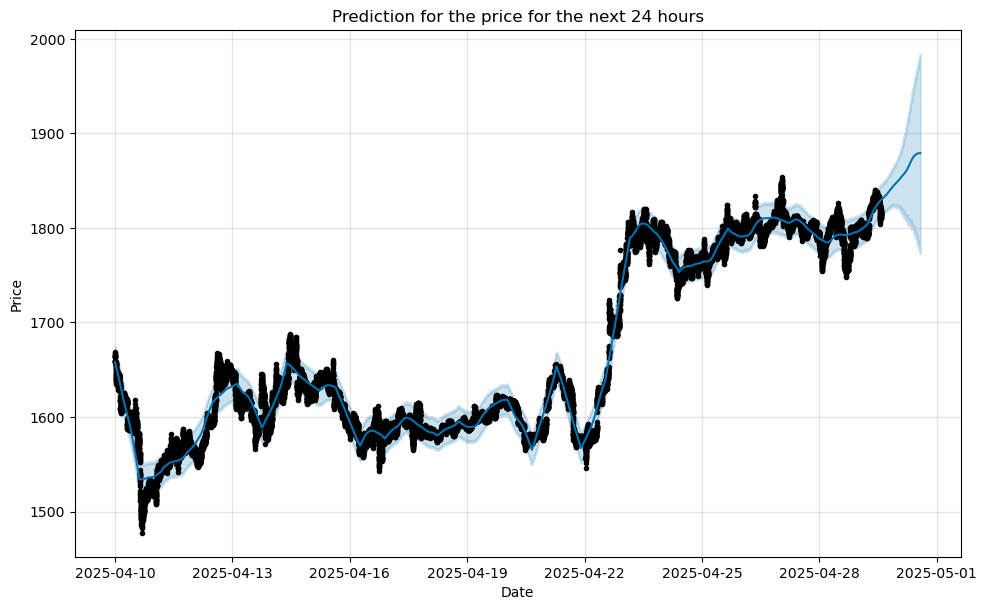

Index(['ds', 'yhat_lower', 'yhat', 'yhat_upper'], dtype='object')


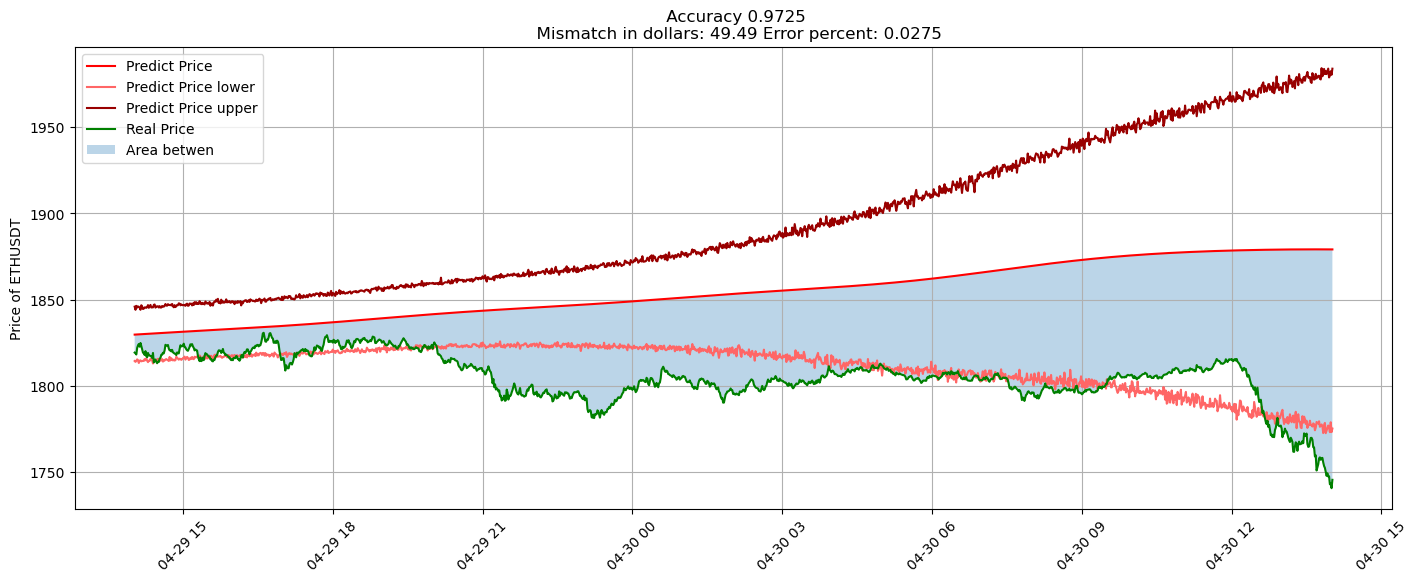

In [41]:
start_time='2025-04-10'
end_time  ='2025-04-29 14:00:00'
time = 'min'
crypto="ETHUSDT"


data = get_data_crypto().download_data(start_time=start_time, end_time=end_time, crypto=crypto, time=time)
df_prophet, predict_prophet = prophet_model(data=data, time=time)
test_1 = data_predict(model_pred=predict_prophet, crypto=crypto, time=time)

In [32]:
test_1

,ds,yhat_lower,yhat,yhat_upper,real price,difference,mismatch
0,2025-05-02 14:02:00,1835.244791,1850.591564,1865.941178,1835.95,14.641564,0.007975
1,2025-05-02 14:03:00,1835.571761,1850.599787,1865.799387,1837.29,13.309787,0.007244
2,2025-05-02 14:04:00,1835.355664,1850.608566,1865.420273,1838.54,12.068566,0.006564
3,2025-05-02 14:05:00,1836.096484,1850.617905,1865.719579,1838.24,12.377905,0.006734
4,2025-05-02 14:06:00,1834.537535,1850.627807,1865.951690,1841.62,9.007807,0.004891
...,...,...,...,...,...,...,...
1435,2025-05-03 13:57:00,1767.095848,1882.163579,2005.217064,1834.44,47.723579,0.026015
1436,2025-05-03 13:58:00,1770.130502,1882.169064,2001.967151,1834.20,47.969064,0.026153
1437,2025-05-03 13:59:00,1768.575095,1882.175090,2004.792306,1834.40,47.775090,0.026044
1438,2025-05-03 14:00:00,1769.853875,1882.181661,2008.279150,1835.20,46.981661,0.025600


In [38]:
24*60

1440

In [34]:
test_1[test_1['ds'] == '2025-05-03 13:00:00']

,ds,yhat_lower,yhat,yhat_upper,real price,difference,mismatch
1378,2025-05-03 13:00:00,1777.127228,1882.583973,1993.760671,1829.59,52.993973,0.028965
